This notebook aims to explore capabilities of the NNs to predict density error based on the information about the <i> density field only</i>. They are compared with deterministic parametrization from the paper (Stanley et al 2020).

# Import

In [1]:
import glob, os
from IPython.display import clear_output
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm, trange
import xarray as xr
import dask
import pandas as pd
from IPython import display
from prettytable import PrettyTable
import pytorch_lightning as pl
from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning.callbacks import EarlyStopping,ModelCheckpoint
import inspect
import tensorboard
from tensorboard.backend.event_processing.event_file_loader import EventFileLoader

In [2]:
import logging
logging.getLogger('lightning').setLevel(0)
pl.utilities.distributed.log.setLevel(logging.ERROR)

In [3]:
import platform
print(platform.platform())

macOS-12.4-arm64-arm-64bit


In [4]:
#device = torch.device("mps")
device = torch.device("cpu")

# Dataset definitions

The proposed implementation of the ``pytorch Dataset`` class reads netcdf files with data and can transform it for pytorch tensors. It allows to choose any number of netcdf files that will form the dataset and adjust the quantity of time snapshots taken from files. It also can perform normalization by mean and std of a variable in the file (so that the average is performed individually for each region and season). It is possible to create a dataset from 1 region and season, or to combine few one them (by combining files) and shuffle the snapshots in the training dataset.

In [6]:
keys_to_add_to_sample = ['sigma0_model', 'sosstsst', 'sosaline', 'diff_S_sqr', 'diff_TS', 'rho_sa_sa', 'rho_sa_ct', 'diff_T_sqr', 'rho_ct_ct', 'sigma0_delta']

In [7]:
class SalinityTemperatureDensityDataset(torch.utils.data.Dataset):
    """Dataset of 2D maps of surface temperature, salinity"""

    def __init__(self, list_of_netcdf_files, select='All', portion_of_time_series=0.5, transform=None, normalize=False):
        self.data = [xr.DataArray() for i in range(len(list_of_netcdf_files))]
        for i, datasetNetcdfFile in enumerate(list_of_netcdf_files) :
            self.data[i] = xr.open_dataset(datasetNetcdfFile).load()
            # nan filling (very draft version of nans treatment)
            self.data[i] = self.data[i].bfill(dim='x')
            if (np.isnan(self.data[i]['diff_S_sqr']).any() or np.isnan(self.data[i]['sigma0_delta']).any()) :
                print("NANS in data " + datasetNetcdfFile)
        data_file_len = len(self.data[0]['time_counter'])
        if (select == 'All') :
            time_index_range = np.arange(0, data_file_len)
        elif (select == 'First') :
            time_index_range = np.arange(0, int(portion_of_time_series*data_file_len)+1)
        elif (select == 'Last') :
            time_index_range = np.arange(int((1-portion_of_time_series)*data_file_len), data_file_len)
        self.total_len = len(self.data)*len(time_index_range)
        self.index_table = np.transpose(np.stack([np.concatenate([np.full(len(time_index_range), i) for i in range(len(self.data))]),\
         np.concatenate([time_index_range for i in range(len(self.data))])]))
        self.transform = transform
        self.normalize = normalize
        if (normalize) :
            for i in range(len(list_of_netcdf_files)) :
                for key in self.data[i].data_vars :
                    self.data[i].attrs['mean_'+key] = self.data[i].data_vars[key].mean().compute()
                    self.data[i].attrs['std_'+key] = self.data[i].data_vars[key].std().compute()
        
    def __len__(self):
        return self.total_len

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        [index_of_dataset, index_of_time_counter] = self.index_table[idx]
        current_dataframe = self.data[index_of_dataset].isel(time_counter=index_of_time_counter).load()
        
        sample = dict()
        sample['dataset_index'] = index_of_dataset
        sample['dataset_region'] = self.data[index_of_dataset].attrs['region']
        sample['dataset_season'] = self.data[index_of_dataset].attrs['season']
        for key in keys_to_add_to_sample :
            if self.normalize :
                # normalize by substracting mean and dividing by std of the FILE dataset (to avoid batch avg)
                sample['mean_'+key] = current_dataframe.attrs['mean_'+key].values
                sample['std_'+key] = current_dataframe.attrs['std_'+key].values
                sample[key] = ((current_dataframe[key]-sample['mean_'+key])/sample['std_'+key]).values
            else : 
                sample[key] = current_dataframe[key].values

        if self.transform:
            sample = self.transform(sample)
        return sample
    
    def restore_units(sample, data, ref_variable) :
        return (sample['std_'+ref_variable].view(-1,1,1)*data+sample['mean_'+ref_variable].view(-1,1,1))
    def normalize(sample, data, ref_variable) :
        return (data-sample['mean_'+ref_variable].view(-1,1,1))/(sample['std_'+ref_variable].view(-1,1,1))

In [8]:
class ToTensor(object):
    """Convert each numpy array in sample to Tensors."""

    def __call__(self, sample):
        transformed_sample=sample
        for key in keys_to_add_to_sample :
            transformed_sample[key] = torch.from_numpy(sample[key].copy())
        return transformed_sample

In [9]:
# test_ds = SalinityTemperatureDensityDataset(list_of_netcdf_files = ['datasets/dataset0.nc'], select='Last', portion_of_time_series=0.6, transform=ToTensor(), normalize=True)

# test_dl = torch.utils.data.DataLoader(dataset=test_ds, batch_size=5, drop_last=True)

# test_di = iter(test_dl)

# sample = next(test_di)

# SalinityTemperatureDensityDataset.restore_units(sample, sample['sigma0_delta'], 'sigma0_delta').shape

# Data properties

In [10]:
list_of_datasets = sorted(glob.glob('datasets/dataset?.nc'))  # put correct path to netcdf files here
print(list_of_datasets)

['datasets/dataset0.nc', 'datasets/dataset1.nc', 'datasets/dataset2.nc', 'datasets/dataset3.nc', 'datasets/dataset4.nc', 'datasets/dataset5.nc']


In [11]:
h = 20 # height of images
w = 20 # width of images

# Useful functions

In [12]:
def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

In [13]:
def get_logs_from_tb(exp_name, version_name, directory='logs/') :
    dictionary = dict()
    # for var in list_of_vars :
    #     dictionary[var] = list()
    for event in EventFileLoader(glob.glob(directory + '/' + exp_name + '/' + version_name + '/events.out.*')[0]).Load() :
        if (len(event.summary.value) > 0) :
            if (event.summary.value[0].tag not in dictionary) :
                dictionary[event.summary.value[0].tag] = []
            (dictionary[event.summary.value[0].tag]).append(event.summary.value[0].tensor.float_val)
    return dictionary

Deterministic parametrization:

In [14]:
# coefficient c in the deterministic parametrization (the one thar is calibrated)
coef_determ_param = 0.1

In [15]:
def determ_param(diff_T_sqr, deriv_rho_TT, c) :
    return 0.5*c*deriv_rho_TT*diff_T_sqr

# Experiment class

In [16]:
class Experiment :
    log_directory='logs/'
    
    def __init__(self, pl_class, model, label, version_name, keys_input, keys_targets, train_dataset, validation_dataset, batch_size=1, max_epochs=None, limit_train_batches=1.0) :
        super().__init__()
        self.pl_class = pl_class
        self.model = model
        self.label = label
        self.version_name = version_name
        self.keys_input = keys_input
        self.keys_targets = keys_targets
        self.train_dataset = train_dataset
        self.validation_dataset = validation_dataset
        self.batch_size = batch_size
        self.max_epochs = max_epochs
        self.limit_train_batches = limit_train_batches
        
    def run(self) :
        self.train_data_loader = torch.utils.data.DataLoader(dataset=self.train_dataset, batch_size=self.batch_size, shuffle=True, drop_last=True)
        self.val_data_loader = torch.utils.data.DataLoader(dataset=self.validation_dataset, batch_size=self.batch_size, drop_last=True)
        self.NN = self.pl_class(self.model, self.keys_input, self.keys_targets)
        self.logger = pl_loggers.TensorBoardLogger(save_dir=self.log_directory, name=self.label, version=self.version_name)
        self.checkpoint_callback = ModelCheckpoint(dirpath=self.log_directory + self.label + "/" + self.version_name, \
                                              save_top_k=2, monitor="loss_val")
    
        self.trainer = pl.Trainer(max_epochs=self.max_epochs, logger=self.logger, limit_train_batches=self.limit_train_batches, \
                                  callbacks=[EarlyStopping(monitor="loss_val", mode="min"), self.checkpoint_callback])  
        self.trainer.fit(model = self.NN, train_dataloaders=self.train_data_loader, val_dataloaders=self.val_data_loader)
        self.logs = get_logs_from_tb(exp_name=self.label, version_name=self.version_name, directory=self.log_directory)
        
    def test(self) :
        # MSE on the frames with restored units
        return self.trainer.test(self.NN, dataloaders=self.val_data_loader)

# Fully-connected NN

In [20]:
eval_loss = torch.nn.MSELoss(reduction='none') 

In [21]:
class LitPixelModel(pl.LightningModule):
    def __init__(self, nnModel, inputs, outputs):
        super().__init__()
        self.nnModel = nnModel
        for name, param in nnModel.named_parameters():
            param.data.normal_(mean=0.0, std=0.1)
        self.inputs = inputs
        self.outputs = outputs
        self.save_hyperparameters()

    def training_step(self, batch, batch_idx) :
        x = self.transform_input(batch)
        y_true = self.transform_target(batch)
        y_model = self.nnModel(x)
        loss = torch.nn.functional.mse_loss(y_model, y_true)  
        self.log('loss_train', loss, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx) :
        x = self.transform_input(batch)
        y_true = self.transform_target(batch)
        y_model = self.nnModel(x)
        loss = torch.nn.functional.mse_loss(y_model, y_true)  
        self.log('loss_val', loss, on_step=False, on_epoch=True) 
    
    def predict_step(self, batch, batch_idx) :
        x = self.transform_input(batch)
        pred = self.nnModel(x).view(-1,h,w)
        return pred
        
    def test_step(self, batch, batch_idx, dataloader_idx) :
        true_output = SalinityTemperatureDensityDataset.restore_units(batch, batch['sigma0_delta'],'sigma0_delta')
        #model_output = SalinityTemperatureDensityDataset.restore_units(batch, batch['sigma0_delta'],'sigma0_delta')
        model_output = SalinityTemperatureDensityDataset.restore_units(batch, self.predict_step(batch, batch_idx), 'sigma0_delta')
        loss = np.squeeze(eval_loss(model_output.view(-1,1), true_output.view(-1,1)))
        self.log('loss_test', loss)

    def configure_optimizers(self) :
        #optimizer = optim.Adam(self.parameters(), lr=1e-3)
        optimizer = torch.optim.SGD(self.parameters(), lr=0.001)
        return optimizer

    def transform_input(self, batch) :
        return torch.hstack([batch[key].view(-1,1) for key in self.inputs]).to(torch.float32)
    def transform_target(self, batch) : 
        return torch.hstack([batch[key].view(-1,1) for key in self.outputs]).to(torch.float32)

In [23]:
layer4_FCNN_model = torch.nn.Sequential(torch.nn.Linear(6, 8), \
                                       torch.nn.ReLU(), \
                                       torch.nn.Linear(8, 16), \
                                       torch.nn.ReLU(), \
                                       torch.nn.Linear(16, 8), \
                                       torch.nn.ReLU(), \
                                       torch.nn.Linear(8, 1))

## Experiment 0

In [28]:
exp0 = Experiment(pl_class=LitPixelModel, \
                      model=layer4_FCNN_model, \
                      label='4_layers', \
                      version_name='version_0', \
                      keys_input={'diff_S_sqr', 'diff_TS', 'rho_sa_sa', 'rho_sa_ct', 'diff_T_sqr', 'rho_ct_ct'}, \
                      keys_targets={'sigma0_delta'}, 
                      train_dataset=SalinityTemperatureDensityDataset(list_of_netcdf_files = list_of_datasets, select='Last', portion_of_time_series=0.6, \
                                                                      transform=ToTensor(), normalize=True), \
                      validation_dataset=SalinityTemperatureDensityDataset(list_of_netcdf_files = list_of_datasets, select='First', portion_of_time_series=0.2, \
                                                                           transform=ToTensor(), normalize=True), \
                      batch_size=4, \
                      max_epochs=25, \
                      limit_train_batches=1.0) 

In [29]:
exp0.run()
clear_output(wait=True)


  | Name    | Type       | Params
---------------------------------------
0 | nnModel | Sequential | 345   
---------------------------------------
345       Trainable params
0         Non-trainable params
345       Total params
0.001     Total estimated model params size (MB)
/opt/homebrew/Caskroom/miniforge/base/envs/new_pytorch/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /Users/ana/CODE/Jupyter_Notebooks/oceanDataNotebooks/density_ML/logs/4_layers/version_0 exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Validation sanity check: 0it [00:00, ?it/s]

/opt/homebrew/Caskroom/miniforge/base/envs/new_pytorch/lib/python3.10/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/opt/homebrew/Caskroom/miniforge/base/envs/new_pytorch/lib/python3.10/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

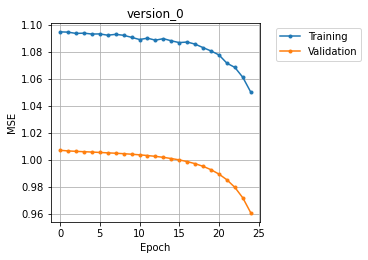

In [30]:
fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(5, 3.5), sharey=True)
ax.plot(exp0.logs['loss_train'], '.-', label='Training')
ax.plot(exp0.logs['loss_val'], '.-', label='Validation')
ax.set(title=exp0.version_name, xlabel='Epoch', ylabel='MSE'); ax.grid(True)
ax.set(ylabel='MSE')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## Test by regions/seasons

In [31]:
test_dataloaders = []
for i, dataset_file in enumerate(list_of_datasets) :
    test_dataloaders.append(torch.utils.data.DataLoader(dataset=SalinityTemperatureDensityDataset(list_of_netcdf_files = [dataset_file], \
                                                                         select='First', \
                                                                         portion_of_time_series=0.2, \
                                                                         transform=ToTensor(), \
                                                                         normalize=True), \
                                                  batch_size=1, drop_last=True))
exp0_MSE_by_regions = [list(test_dict.values())[0] for test_dict in exp0.trainer.test(dataloaders=test_dataloaders, ckpt_path='best')]

/opt/homebrew/Caskroom/miniforge/base/envs/new_pytorch/lib/python3.10/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/opt/homebrew/Caskroom/miniforge/base/envs/new_pytorch/lib/python3.10/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, test_dataloader 1, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/opt/homebrew/Caskroom/miniforge/base/envs/new_pytorch/lib/python3.10/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, test_dataloade

Testing: 0it [00:00, ?it/s]

/opt/homebrew/Caskroom/miniforge/base/envs/new_pytorch/lib/python3.10/site-packages/pytorch_lightning/utilities/data.py:59: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 1. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss_test/dataloader_idx_0': 2.6251969757140614e-05}
--------------------------------------------------------------------------------
DATALOADER:1 TEST RESULTS
{'loss_test/dataloader_idx_1': 9.0395014922251e-06}
--------------------------------------------------------------------------------
DATALOADER:2 TEST RESULTS
{'loss_test/dataloader_idx_2': 3.0649924820380647e-09}
--------------------------------------------------------------------------------
DATALOADER:3 TEST RESULTS
{'loss_test/dataloader_idx_3': 3.980819940352376e-08}
--------------------------------------------------------------------------------
DATALOADER:4 TEST RESULTS
{'loss_test/dataloader_idx_4': 1.0424021645860648e-08}
--------------------------------------------------------------------------------
DATALOADER:5 TEST RESULTS
{'loss_test/dataloader_idx_5': 2.9133383705470806e-08}
--------------------------------

In [32]:
exp0_MSE_by_regions

[2.6251969757140614e-05,
 9.0395014922251e-06,
 3.0649924820380647e-09,
 3.980819940352376e-08,
 1.0424021645860648e-08,
 2.9133383705470806e-08]

# Convolutional NN model

In [53]:
layers3_CNN = torch.nn.Sequential(torch.nn.Conv2d(2, 32, kernel_size=3, padding='same', padding_mode='replicate'), \
                                  torch.nn.ReLU(), \
                                  torch.nn.Conv2d(32, 64, kernel_size=3, padding='same', padding_mode='replicate') ,
                                  torch.nn.ReLU(), \
                                  torch.nn.Conv2d(64, 1, kernel_size=3, padding='same', padding_mode='replicate')).double()

In [73]:
class CNN_Model_Class(pl.LightningModule):
    def __init__(self, nnModel, inputs, outputs):
        super().__init__()
        self.nnModel = nnModel
        for name, param in nnModel.named_parameters():
            param.data.normal_(mean=0.0, std=0.1)
        self.inputs = inputs
        self.outputs = outputs
        self.save_hyperparameters()

    def training_step(self, batch, batch_idx) :
        x = self.transform_input(batch)
        y_true = self.transform_target(batch)
        y_model = self.nnModel(x)
        loss = torch.nn.functional.mse_loss(y_model, y_true)  
        self.log('loss_train', loss, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx) :
        x = self.transform_input(batch)
        y_true = self.transform_target(batch)
        y_model = self.nnModel(x)
        loss = torch.nn.functional.mse_loss(y_model, y_true)  
        self.log('loss_val', loss, on_step=False, on_epoch=True) 
    
    def predict_step(self, batch, batch_idx) :
        x = self.transform_input(batch)
        pred = self.nnModel(x).view(-1,len(self.outputs),h,w)
        return pred
        
    def test_step(self, batch, batch_idx, dataloader_idx) :
        true_output = SalinityTemperatureDensityDataset.restore_units(batch, batch['sigma0_delta'],'sigma0_delta')
        #model_output = SalinityTemperatureDensityDataset.restore_units(batch, batch['sigma0_delta'],'sigma0_delta')
        model_output = SalinityTemperatureDensityDataset.restore_units(batch, self.predict_step(batch, batch_idx), 'sigma0_delta')
        loss = np.squeeze(eval_loss(model_output.view(-1,1), true_output.view(-1,1)))
        self.log('loss_test', loss)

    def configure_optimizers(self) :
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        #optimizer = torch.optim.SGD(self.parameters(), lr=0.001)
        return optimizer

    def transform_input(self, batch) :
        return torch.transpose(torch.stack([batch[key] for key in self.inputs]), 0, 1)
    def transform_target(self, batch) : 
        return torch.transpose(torch.stack([batch[key] for key in self.outputs]), 0, 1)

In [74]:
# print('Input data for training contains ' + str(len(train_data_loader)) + ' batches, each batch contains ' + str(batch_size) + \
#       ' instanteneous 2D maps of ' +str(len(keys_input_CNN)) + ' channels: ' + str(keys_input_CNN) + ' of size ' + str(h)+'x'+str(w) + ' pixels.')

## Experiment 1

In [149]:
exp1 = Experiment(pl_class=CNN_Model_Class, \
                      model=layers3_CNN, \
                      label='CNN', \
                      version_name='version_0', \
                      keys_input={'sosstsst', 'rho_ct_ct'}, \
                      keys_targets={'sigma0_delta'}, 
                      train_dataset=SalinityTemperatureDensityDataset(list_of_netcdf_files = list_of_datasets, select='Last', portion_of_time_series=0.6, \
                                                                      transform=ToTensor(), normalize=True), \
                      validation_dataset=SalinityTemperatureDensityDataset(list_of_netcdf_files = list_of_datasets, select='First', portion_of_time_series=0.2, \
                                                                           transform=ToTensor(), normalize=True), \
                      batch_size=4, \
                      max_epochs=30, \
                      limit_train_batches=1.0) 

In [150]:
exp1.run()
clear_output(wait=True)


  | Name    | Type       | Params
---------------------------------------
0 | nnModel | Sequential | 19.7 K
---------------------------------------
19.7 K    Trainable params
0         Non-trainable params
19.7 K    Total params
0.079     Total estimated model params size (MB)
/opt/homebrew/Caskroom/miniforge/base/envs/new_pytorch/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /Users/ana/CODE/Jupyter_Notebooks/oceanDataNotebooks/density_ML/logs/CNN/version_0 exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Validation sanity check: 0it [00:00, ?it/s]

/opt/homebrew/Caskroom/miniforge/base/envs/new_pytorch/lib/python3.10/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/opt/homebrew/Caskroom/miniforge/base/envs/new_pytorch/lib/python3.10/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

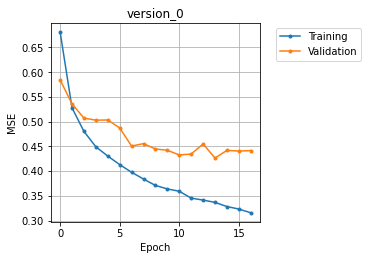

In [151]:
fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(5, 3.5), sharey=True)
ax.plot(exp1.logs['loss_train'], '.-', label='Training')
ax.plot(exp1.logs['loss_val'], '.-', label='Validation')
ax.set(title=exp1.version_name, xlabel='Epoch', ylabel='MSE'); ax.grid(True)
ax.set(ylabel='MSE')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Compare results with deterministic parametrization

## Image example

In [152]:
test_dl = torch.utils.data.DataLoader(dataset=SalinityTemperatureDensityDataset(list_of_netcdf_files = list_of_datasets, \
                                            select='First', \
                                            portion_of_time_series=0.2, \
                                            transform=ToTensor(), \
                                            normalize=True),\
                                      batch_size=1, drop_last=True, shuffle=True)

In [159]:
best_FCNN_model = LitPixelModel.load_from_checkpoint(exp0.checkpoint_callback.best_model_path)
best_CNN_model = CNN_Model_Class.load_from_checkpoint(exp1.checkpoint_callback.best_model_path)

In [160]:
test_di = iter(test_dl)

In [165]:
sample = next(test_di)

In [166]:
# snapshot = dict()
# snapshot['true_error'] = np.squeeze(SalinityTemperatureDensityDataset.restore_units(sample,sample['sigma0_delta'],'sigma0_delta'))
# snapshot['FCNN'] = np.squeeze(SalinityTemperatureDensityDataset.restore_units(sample, \
#                                                                               LitPixelModel.load_from_checkpoint(exp0.checkpoint_callback.best_model_path).\
#                                                                               predict_step(sample, 0),'sigma0_delta').detach().numpy())
# snapshot['CNN'] = np.squeeze(SalinityTemperatureDensityDataset.restore_units(sample, \
#                                 CNN_Model_Class.load_from_checkpoint(exp1.checkpoint_callback.best_model_path).predict_step(sample, 0),\
#                                 'sigma0_delta').detach().cpu().numpy())
# snapshot['determ_param'] = np.squeeze(determ_param(SalinityTemperatureDensityDataset.restore_units(sample,sample['diff_T_sqr'],'diff_T_sqr'), \
#                                         SalinityTemperatureDensityDataset.restore_units(sample,sample['rho_ct_ct'],'rho_ct_ct'), \
#                                         coef_determ_param).numpy())

In [169]:
snapshot = dict()
snapshot['true_error'] = np.squeeze(sample['sigma0_delta'])
snapshot['FCNN'] = np.squeeze(best_FCNN_model.predict_step(sample, 0).detach().numpy())
snapshot['CNN'] = np.squeeze(best_CNN_model.predict_step(sample, 0).detach().cpu().numpy())
snapshot['determ_param'] = np.squeeze(SalinityTemperatureDensityDataset.normalize(sample, determ_param(SalinityTemperatureDensityDataset.restore_units(sample,sample['diff_T_sqr'],'diff_T_sqr'), \
                                        SalinityTemperatureDensityDataset.restore_units(sample,sample['rho_ct_ct'],'rho_ct_ct'), \
                                        coef_determ_param),'sigma0_delta'))

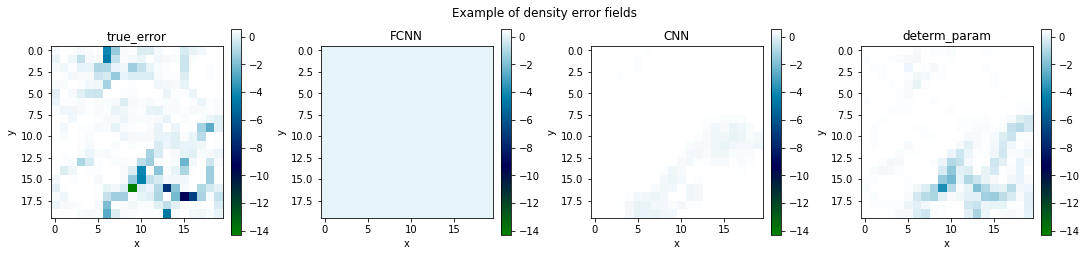

In [170]:
fig, ax = plt.subplots(ncols=len(snapshot.keys()), nrows=1, figsize=(15,3.5), constrained_layout=True)
fig.suptitle('Example of density error fields')
for i, key in enumerate(['true_error', 'FCNN', 'CNN', 'determ_param']) :
    if i == 0 :
        img = ax[i].imshow(snapshot[key], cmap='ocean')
        fig.colorbar(img, ax=ax[i])
        color_min = img.colorbar.vmin
        color_max = img.colorbar.vmax
    else :
        img = ax[i].imshow(snapshot[key], cmap='ocean', vmin=color_min, vmax=color_max)
        fig.colorbar(img, ax=ax[i])
    ax[i].set(title=key, xlabel='x', ylabel='y')
plt.show()

# Evaluation

## Total MSE on a dataset

In [187]:
eval_loss = nn.MSELoss(reduction='none') 

In [188]:
MSE = dict({'determ_param': [], 'FCNN': []})
MSE['determ_param'] = [ list() for i in range(len(list_of_datasets))]
MSE['FCNN' ] = [ list() for i in range(len(list_of_datasets))]
MSE['CNN' ] = [ list() for i in range(len(list_of_datasets))]
labels = ['' for i in range(len(list_of_datasets))]

In [189]:
%%time
for i in range(len(list_of_datasets)) :
    single_dataset = SalinityTemperatureDensityDataset(list_of_netcdf_files = [list_of_datasets[i]], select='Last', \
                                                 portion_of_time_series=0.2, transform=ToTensor(), normalize=True)
    eval_data_loader = DataLoader(dataset=single_dataset, batch_size=1, shuffle=False)
    current_list_FCNN = []; current_list_CNN = []; current_list_param = []
    for j, sample in enumerate(eval_data_loader) :
        true_error = restore_units(sample,sample['sigma0_delta'],'sigma0_delta',0).view(-1,1).to(torch.float32).to(device)
        FCNN_error = restore_units(sample, modelFCNN(transform_input(sample)).view(1,w,h),'sigma0_delta',0).view(-1,1)
        CNN_error = restore_units(sample, modelCNN(transform_input_CNN(sample)).view(1,w,h),'sigma0_delta',0).view(-1,1)
        determ_param_error = determ_param(restore_units(sample,sample['diff_T_sqr'],'diff_T_sqr',0), \
                                        restore_units(sample,sample['rho_ct_ct'],'rho_ct_ct',0), \
                                        coef_determ_param).view(-1,1).to(torch.float32).to(device)
        current_list_FCNN = current_list_FCNN + list(np.squeeze(eval_loss(FCNN_error, true_error).detach().cpu().numpy()))
        current_list_CNN = current_list_CNN + list(np.squeeze(eval_loss(CNN_error, true_error).detach().cpu().numpy()))
        current_list_param = current_list_param + list(np.squeeze(eval_loss(determ_param_error, true_error).detach().cpu().numpy()))
    MSE['FCNN'][i] = current_list_FCNN
    MSE['CNN'][i] = current_list_CNN
    MSE['determ_param'][i] = current_list_param
    labels[i] = 'Reg ' + sample['dataset_region'][0] + ' ' + sample['dataset_season'][0]

CPU times: user 2.98 s, sys: 919 ms, total: 3.9 s
Wall time: 3.69 s


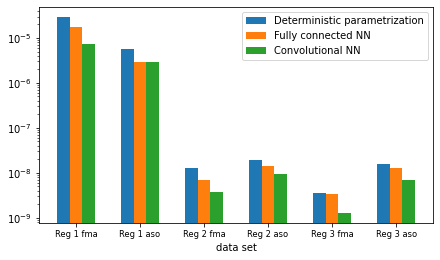

In [190]:
fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(6, 3.5))
#fig.suptitle(r'Spatial correlation coefficient averaged in time: $R(\rho_c, parametrization)$')
x = np.arange(len(list_of_datasets))
bar_width = 0.2

for i, key in enumerate(['determ_param', 'FCNN', 'CNN']) :
    ax.bar(x+i*bar_width, [np.mean(MSE[key][region]) for region in range(len(list_of_datasets))], width=bar_width, label=key)
ax.legend(['Deterministic parametrization', 'Fully connected NN', 'Convolutional NN'])
ax.set_xticks(x+bar_width)
#ax.axhline(y=1., color='k')
ax.set_xticklabels(labels,fontsize=10)
ax.set_xlabel('data set')
ax.xaxis.set_tick_params(labelsize='small')
ax.set(yscale='log')
plt.show()

## Histograms of MSE

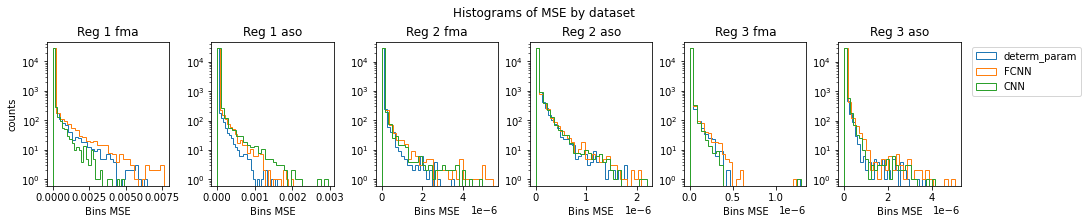

In [64]:
fig, ax = plt.subplots(1, 6, constrained_layout=True, figsize=(15, 3))
fig.suptitle('Histograms of MSE by dataset')
for key in ['determ_param', 'FCNN', 'CNN'] :
    for i in range(len(list_of_datasets)) :
        ax[i].hist(MSE[key][i], bins=30, histtype='step', density=False, label=key)
        ax[i].set(yscale='log', title=labels[i], xlabel='Bins MSE')
ax[0].set(ylabel='counts')
ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()